In [187]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VARMAX

import seaborn as sns
from datetime import datetime

In [109]:
# define helper functions

# remove outliers xx percentile
def remove_outliers(df, column, percentile = 0.99):
    thresh = df[column].quantile(percentile)
    return df[df[column] <= thresh]

# test if stationary
def test_stationary(df, column):
    result = adfuller(df[column], autolag = 'AIC')
    return result[0] < result[4]['5%']

def granger_test(df, X, Y, lags = 1):
    result = grangercausalitytests(df[[Y, X]], lags)
    return result.get(1)[0].get('ssr_ftest')[1]

# seasonal decompose, additive/multiplicative
def decompose(df, column, add_mult = 'additive', freq = 300):
    res = seasonal_decompose(df[column], model = add_mult, period = freq, extrapolate_trend='freq')
    return res

def find_season(df, column, fmax = 300):
    residuals = []
    for i in range(2, fmax):
        result = decompose(df, column, freq = i)
        residuals.append(abs(result.resid.mean()))
    return np.array(residuals).argmin()+2

def return_dummies(df, column, pref = 'day'):
    return pd.get_dummies(df, columns = [column], prefix = pref)

In [110]:
#read the data
data_df = pd.read_csv('data/train.csv', encoding="ISO-8859-1", low_memory=False)

In [111]:
# choose a store
store_id = 8

In [140]:
# extract the data for "store_id", choose only data on open days
store_df = data_df.query(f'Store == {store_id} and Open == 1')

In [141]:
# sanity check
store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
7,8,5,2015-07-31,8492,833,1,1,0,1
1122,8,4,2015-07-30,8420,882,1,1,0,1
2237,8,3,2015-07-29,7029,698,1,1,0,1
3352,8,2,2015-07-28,6717,695,1,1,0,1
4467,8,1,2015-07-27,8739,841,1,1,0,1


In [142]:
store_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1009412,8,1,2013-01-07,7416,802,1,1,0,0
1011642,8,6,2013-01-05,2337,312,1,0,0,0
1012757,8,5,2013-01-04,4059,517,1,0,0,1
1013872,8,4,2013-01-03,4842,662,1,0,0,1
1014987,8,3,2013-01-02,5419,698,1,0,0,1


In [143]:
# reverse the order...
# data should run from past to present ...
store_df = store_df.iloc[::-1]

In [144]:
store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1014987,8,3,2013-01-02,5419,698,1,0,0,1
1013872,8,4,2013-01-03,4842,662,1,0,0,1
1012757,8,5,2013-01-04,4059,517,1,0,0,1
1011642,8,6,2013-01-05,2337,312,1,0,0,0
1009412,8,1,2013-01-07,7416,802,1,1,0,0


In [145]:
# reset index
store_df = store_df.reset_index(drop=True)

In [146]:
store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,8,3,2013-01-02,5419,698,1,0,0,1
1,8,4,2013-01-03,4842,662,1,0,0,1
2,8,5,2013-01-04,4059,517,1,0,0,1
3,8,6,2013-01-05,2337,312,1,0,0,0
4,8,1,2013-01-07,7416,802,1,1,0,0


In [147]:
# check for missing values
store_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

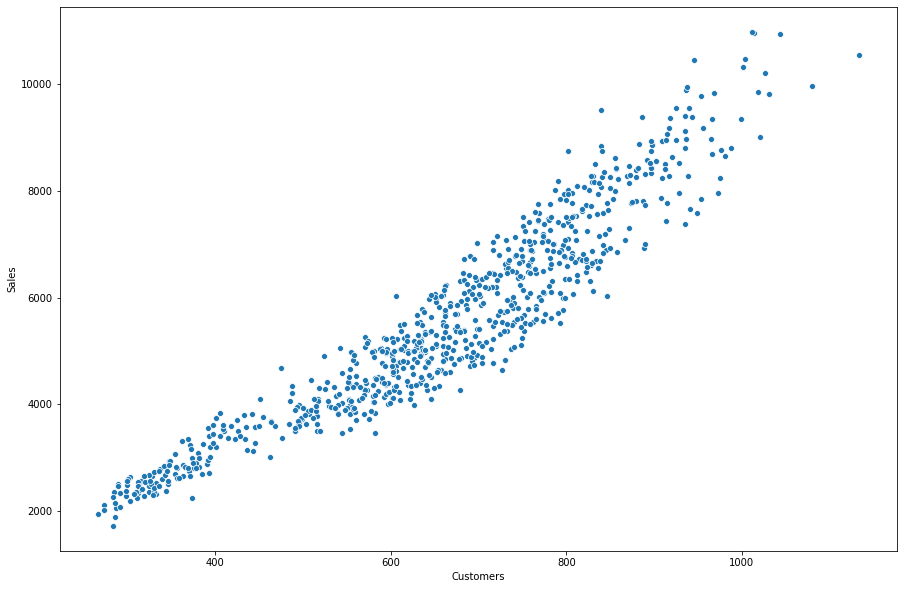

In [148]:
# visual inspection of sales(customers)
plt.figure(figsize = (15,10))
sns.scatterplot(data = store_df, x = 'Customers', y = 'Sales')

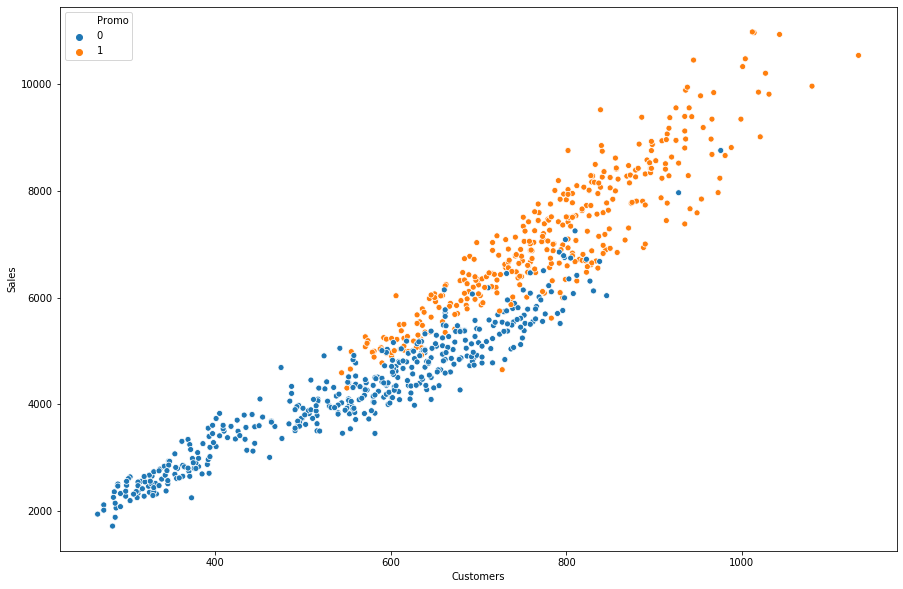

In [149]:
# visual inspection of sales(customers) and add promo influence
plt.figure(figsize = (15,10))
sns.scatterplot(data = store_df, x = 'Customers', y = 'Sales', hue = 'Promo')

- even visually there is an obvious correlation between sales and customers
- a slightly higher sales happens when promo is available
- also promo seems to attract more customers per day

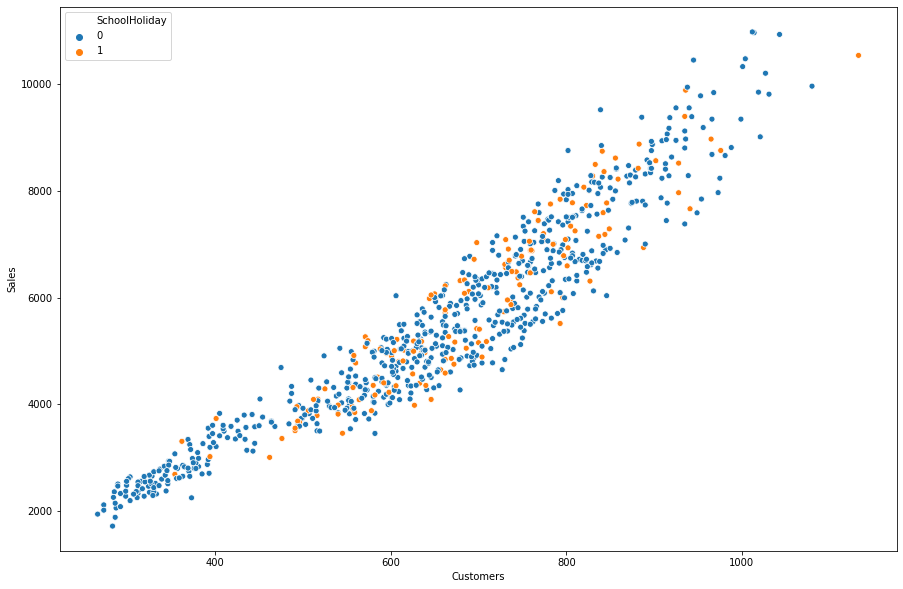

In [150]:
# check schoolholiday influence
plt.figure(figsize = (15,10))
sns.scatterplot(data = store_df, x = 'Customers', y = 'Sales', hue = 'SchoolHoliday')

- worth noting, outliers on both ends happen on school holiday...
- overall small effect

In [151]:
# months
store_df['month'] = store_df.Date.apply(lambda str_: datetime.strptime(str_, '%Y-%m-%d').month)

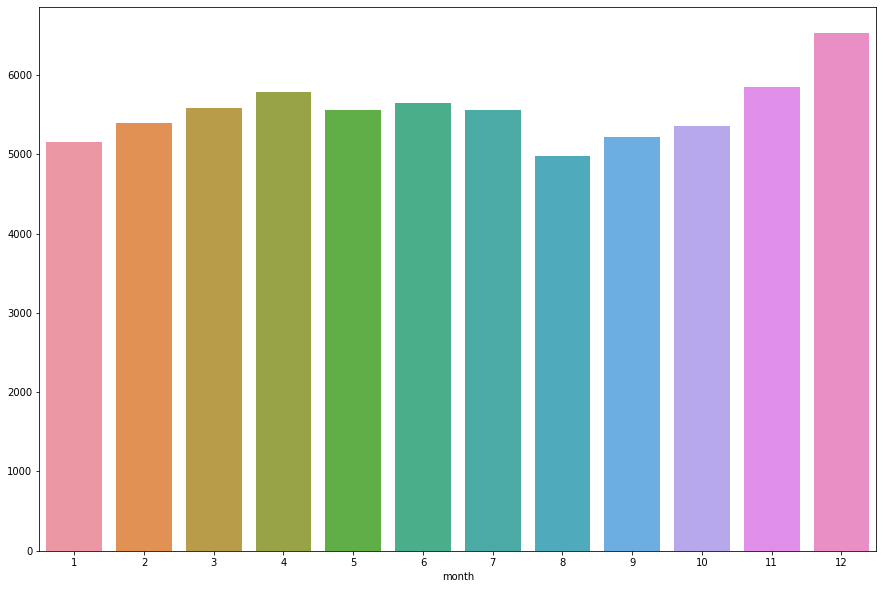

In [152]:
# check some month or weekday effects
result = store_df.groupby(['month']).mean().Sales
plt.figure(figsize = (15,10))
sns.barplot(x = result.index, y = result.values)

- easter seems to have a small effect on sales
- christmas seems to have an even bigger effect on sales

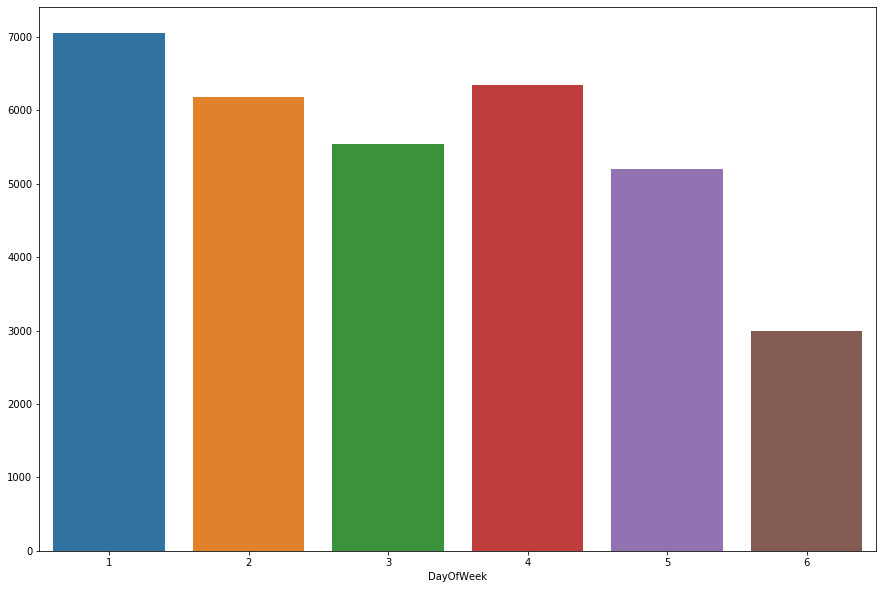

In [153]:
# check for weekdays
result = store_df.groupby(['DayOfWeek']).mean().Sales
plt.figure(figsize = (15,10))
sns.barplot(x = result.index, y = result.values)

- in average, slightly more sales on mondays...even at rossmann

In [154]:
# create dummies for weekdays and months
store_dummies = return_dummies(store_df, 'DayOfWeek', pref = 'day')
store_dummies = return_dummies(store_dummies, 'month', pref = 'month')

In [155]:
store_dummies.head()

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,day_1,day_2,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,8,2013-01-02,5419,698,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,2013-01-03,4842,662,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8,2013-01-04,4059,517,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8,2013-01-05,2337,312,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,2013-01-07,7416,802,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [156]:
# drop store, date, open, stateholiday
store_dummies = store_dummies.drop(['Store', 'Date', 'Open','StateHoliday'], axis = 1)

In [157]:
# remove outliers
store_dummies = remove_outliers(store_dummies, 'Sales')

In [158]:
# decompose the timeseries
# find the frequency with the lowest error
f_sales = find_season(store_dummies, 'Sales')
f_customers = find_season(store_dummies, 'Customers')

In [159]:
result = decompose(store_dummies, 'Sales', freq = f_sales)

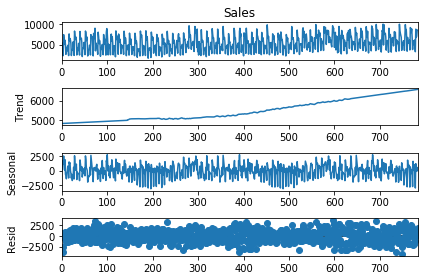

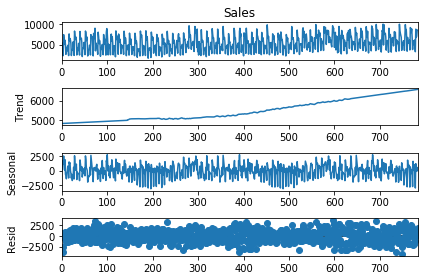

In [160]:
result.plot()

In [161]:
# save the trend and seasonality as features
store_dummies['Sales_trend'] = result.trend
store_dummies['Sales_season'] = result.seasonal

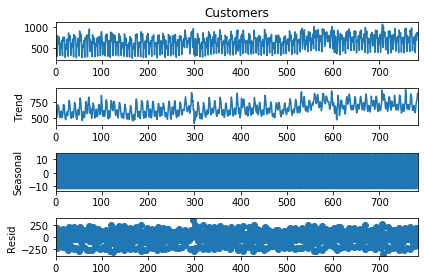

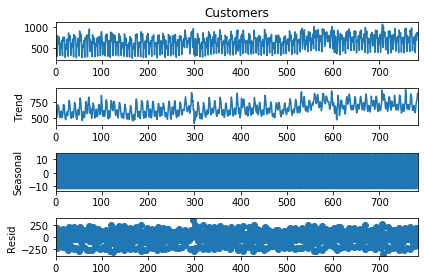

In [162]:
# same for customers
result = decompose(store_dummies, 'Customers', freq = f_customers)
result.plot()

In [163]:
store_dummies['Customers_trend'] = result.trend
store_dummies['Customers_season'] = result.seasonal

In [164]:
# check for stationary
# sales
test_stationary(store_dummies, 'Sales')

True

In [165]:
# customers
test_stationary(store_dummies, 'Customers')

True

In [166]:
# granger
granger_test(store_dummies, 'Customers', 'Sales', lags = 1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=171.7635, p=0.0000  , df_denom=772, df_num=1
ssr based chi2 test:   chi2=172.4309, p=0.0000  , df=1
likelihood ratio test: chi2=155.6905, p=0.0000  , df=1
parameter F test:         F=171.7635, p=0.0000  , df_denom=772, df_num=1


1.4078965478701753e-35

In [167]:
# granger
granger_test(store_dummies, 'Sales', 'Customers', lags = 1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=107.0836, p=0.0000  , df_denom=772, df_num=1
ssr based chi2 test:   chi2=107.4998, p=0.0000  , df=1
likelihood ratio test: chi2=100.6690, p=0.0000  , df=1
parameter F test:         F=107.0836, p=0.0000  , df_denom=772, df_num=1


1.3671389080044935e-23

- both granger cause each other ...

In [195]:
# split in train and testset
test_size = 40 # 6 weeks á 6 days a week (sundays are off in germany...) are 36, with 40 days seems fair enough
train_df, test_df = store_dummies.iloc[:-1*test_size], store_dummies.iloc[-1*test_size:]

In [191]:
# define endogenouse and exogenous variables
endog = train_df[['Sales','Customers']].astype('float32')
exog = train_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

In [192]:
# define VAR model
model = VAR(endog, exog = exog)
result = model.select_order()
result.summary()

C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,AIC,BIC,FPE,HQIC
0,19.42,19.74,2.718e+08,19.54
1,19.13,19.47,2.027e+08,19.26
2,19.06,19.43,1.888e+08,19.20
3,19.05,19.44,1.868e+08,19.20
4,19.03,19.45,1.833e+08,19.19
5,19.01,19.46,1.811e+08,19.19
6,18.95*,19.43*,1.702e+08*,19.14*
7,18.95,19.45,1.704e+08,19.15
8,18.95,19.48,1.705e+08,19.16
9,18.96,19.51,1.715e+08,19.17


In [193]:
print(minimum)
result=model.fit(maxlags = minimum, ic='aic')
lag_order = result.k_ar
result.summary()

6


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 01, Jan, 2021
Time:                     10:40:51
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    19.3941
Nobs:                     730.000    HQIC:                   19.1081
Log likelihood:          -8906.55    FPE:                1.66196e+08
AIC:                      18.9285    Det(Omega_mle):     1.50548e+08
--------------------------------------------------------------------
Results for equation Sales
                           coefficient         std. error           t-stat            prob
------------------------------------------------------------------------------------------
const             -231523939266.786499  1314931463.429042         -176.073           0.000
Promo                       957.115639          84.714955           11.298           0.000
SchoolHoliday       

In [194]:
# train a varmax model
max_model = VARMAX(endog, exog = exog, order = (6,0), trend = 'n') 
max_result = max_model.fit(maxiter = 1000, disp = False)

print(max_result.summary())
print(max_result.params)

C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  736
Model:                            VARX(6)   Log Likelihood               -9644.522
Date:                    Fri, 01 Jan 2021   AIC                          19439.044
Time:                            10:44:07   BIC                          19784.137
Sample:                                 0   HQIC                         19572.133
                                    - 736                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):                54.56, 71.18   Jarque-Bera (JB):       132.31, 262.87
Prob(Q):                        0.06, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.65, 1.99   Skew:                      0.58, -0.05
Prob(H) (two-sided):            0.00, 0.00   Kurtosis:                   4.73, 5.93


In [196]:
# define endogenouse and exogenous variables
endog = test_df[['Sales','Customers']].astype('float32')
exog = test_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

In [197]:
predicted_df = max_result.forecast(steps = 40, exog = exog)

C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


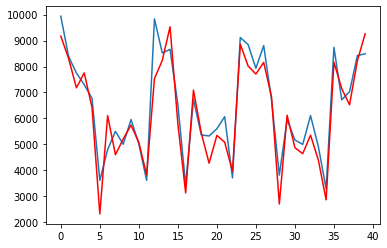

0.04810866791993127
0.09222749592760253


In [198]:
import matplotlib.pyplot as plt

actual=endog[["Sales"]]

actual.columns=['ActualSales']
actual=actual.reset_index(drop=True)
predicted=predicted_df[['Sales']]
predicted=predicted.reset_index(drop=True)
pred=pd.merge(actual, predicted, right_index=True, left_index=True)
pred = pred[pred.ActualSales != 0]


# plot
plt.plot(actual)
plt.plot(predicted, color='red')
plt.show()

MPE=np.mean((pred.ActualSales-pred.Sales)/(pred.ActualSales))
print(MPE)

MAPE=np.mean(abs(pred.ActualSales-pred.Sales)/(pred.ActualSales))
print(MAPE)